In [2]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=b5793f6af71dc540d34143a88f290d923531024e5ffe43645ab23e55d87324cf
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [3]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 35.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 2.9 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.6-cp310-cp310-linux_x86_64.whl size=293632 sha256=0e3a2b626dab4d71a90b6aebecff8dd48862f028a823c9cf1f9075ddaf686c30
  Stored in directory: /root/.cache/pip/wheels/4b/b9/b0/83d6e258e8f963f5ff111a2cd8c483ca59372a86e6a2535212
Successfully built peewee


In [4]:
import yfinance as yf
import pandas as pd
import os
import pandas_ta as ta
import numpy as np

In [5]:
def data(ticker):
  df = yf.Ticker(ticker)
  df = df.history(period="max")
  df.index = pd.to_datetime(df.index)
  del df["Dividends"]
  del df["Stock Splits"]
  df = df.loc["2014-01-01":].copy()
  df["Target"] = (df["Close"] > df["Open"]).astype(int).shift(-1)   ##Binary target...tomorrow increase or decrease direction as an output to be decided by todays statistics
  # frequency = df['Target'].value_counts()
  # print(frequency)
  df.dropna(inplace=True)
  return df

In [6]:
nifty=data("^NSEI")

In [7]:
nifty

,Open,High,Low,Close,Volume,Target
Date,,,,,,
2014-01-02 00:00:00+05:30,6301.250000,6358.299805,6211.299805,6221.149902,158100,1.0
2014-01-03 00:00:00+05:30,6194.549805,6221.700195,6171.250000,6211.149902,139000,0.0
2014-01-06 00:00:00+05:30,6220.850098,6224.700195,6170.250000,6191.450195,118300,0.0
2014-01-07 00:00:00+05:30,6203.899902,6221.500000,6144.750000,6162.250000,138600,0.0
2014-01-08 00:00:00+05:30,6178.049805,6192.100098,6160.350098,6174.600098,146900,0.0
...,...,...,...,...,...,...
2024-07-10 00:00:00+05:30,24459.849609,24461.050781,24141.800781,24324.449219,292300,0.0
2024-07-11 00:00:00+05:30,24396.550781,24402.650391,24193.750000,24315.949219,306400,1.0
2024-07-12 00:00:00+05:30,24387.949219,24592.199219,24331.150391,24502.150391,325800,0.0


<Axes: xlabel='Date'>

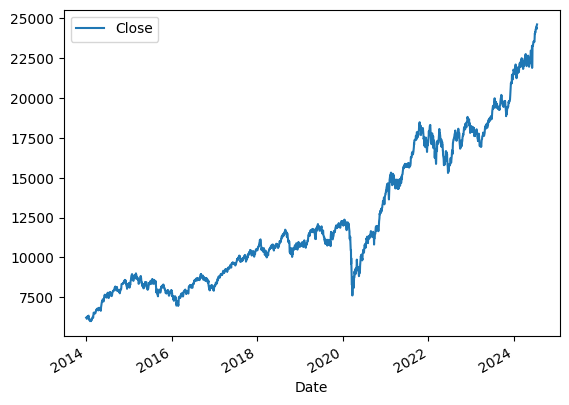

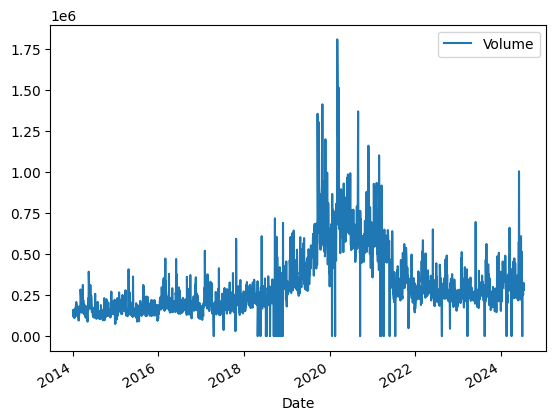

In [8]:
nifty.plot.line(y="Close", use_index=True)
nifty.plot.line(y="Volume", use_index=True)

**First we are going to make a simple model with less features using random forest classifier of sklearn module**(which will predict whether the stock price will go up(1) or down(0) tomorrow) :

In [9]:
nifty=data("^NSEI")
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=300, min_samples_split=2, random_state=50,n_jobs=-1)
train= nifty.iloc[:-200]
test = nifty.iloc[-200:-1]
features = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[features], train["Target"])
print(model.feature_importances_)
print("Training score",model.score(train[features], train["Target"]))

[0.19914937 0.21818412 0.19767964 0.19185017 0.1931367 ]
Training score 1.0


Following are the results of the predictions of the model whether stock price will increase or decrease tomorrow using only "Close", "Volume", "Open", "High", "Low" prices of today :


In [10]:
from sklearn.metrics import accuracy_score

prediction = model.predict(test[features])
prediction = pd.Series(prediction, index=test.index)
print("Accuracy Score",accuracy_score(test["Target"], prediction))

Accuracy Score 0.5025125628140703


**For the following model, various indicators will be used (using pandas_ta) :**

In [1]:
# Calculating technical indicators using pandas_ta
nifty=data("^NSEI")
nifty['SMA_5'] = ta.sma(nifty['Close'], length=5)
nifty['EMA_5'] = ta.ema(nifty['Close'], length=5)
nifty['RSI_14'] = ta.rsi(nifty['Close'], length=14)
macd = ta.macd(nifty['Close'])
# nifty['MACD'] = macd['MACD_12_26_9']
nifty['MACD_signal'] = macd['MACDs_12_26_9']
# nifty['MACD_hist'] = macd['MACDh_12_26_9']
nifty['ATR'] = ta.atr(nifty['High'], nifty['Low'], nifty['Close'], length=14)
nifty['OBV'] = ta.obv(nifty['Close'], nifty['Volume'])
bbands = ta.bbands(nifty['Close'], length=20)
# nifty['Upper_BB'] = bbands['BBU_20_2.0']
# nifty['Middle_BB'] = bbands['BBM_20_2.0']
# nifty['Lower_BB'] = bbands['BBL_20_2.0']

# Lagged features (kind of last five rows to predict the next row)
for lag in range(1, 6):  # Example: 1 to 5 days lag
    # lag-=1
    nifty[f'Close_t-{lag}'] = nifty['Close'].shift(lag)
    nifty[f'Open_t-{lag}'] = nifty['Open'].shift(lag)
    nifty[f'High_t-{lag}'] = nifty['High'].shift(lag)
    nifty[f'Low_t-{lag}'] = nifty['Low'].shift(lag)
    nifty[f'Volume_t-{lag}'] = nifty['Volume'].shift(lag)

# NaN values will be obviously generated by shifting
nifty = nifty.dropna()

nifty

NameError: name 'data' is not defined

Lets firstly define all of these things features...later we will find which ones are more important(or all of them are :)


In [15]:
# Define features and target variable
featuresl = [
    'Close_t-1', 'Close_t-2', 'Close_t-3', 'Close_t-4', 'Close_t-5',
    'Open_t-1', 'High_t-1', 'Low_t-1', 'Volume_t-1',
    'SMA_10', 'EMA_10', 'RSI_14', 'MACD', 'MACD_signal', 'MACD_hist',
    'ATR', 'OBV', 'Upper_BB', 'Middle_BB', 'Lower_BB',
]
featuresq =['SMA_10', 'EMA_10', 'RSI_14', 'MACD', 'MACD_signal', 'MACD_hist',
    'ATR', 'OBV', 'Upper_BB', 'Middle_BB', 'Lower_BB','Open','High','Low','Close','Volume']  ##without lagged features
features =['SMA_10', 'EMA_10', 'RSI_14', 'MACD', 'MACD_signal','Middle_BB','Open','Close','Volume']  ##without lagged features
X = nifty[featuresq]
y = nifty['Target']  # Binary target: 0 for price decrease, 1 for price increase

Lets now build the model, using same parameters(later will tune them too) :

In [21]:
# Train-test split while maintaining the temporal order
train_size = int(len(X) * 0.95)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
model = RandomForestClassifier(n_estimators=385, min_samples_split=17, random_state=6,min_samples_leaf=1,max_features=10,n_jobs=-1)
model.fit(X_train, y_train)
print(model.feature_importances_)
#Training set results
prediction = model.predict(X_train)
prediction = pd.Series(prediction, index=X_train.index)
df=pd.concat([y_train, prediction], axis=1)
# display(df)
print("Accuracy Score",accuracy_score(y_train, prediction))

[0.037131   0.02956049 0.10479848 0.08116557 0.08346858 0.1020043
 0.09601679 0.07138055 0.04548585 0.03519535 0.05106729 0.04014034
 0.03298451 0.03268549 0.03928704 0.11762837]
Accuracy Score 0.9678217821782178


In [22]:
#Testing set results
prediction = model.predict(X_test)
prediction = pd.Series(prediction, index=X_test.index)
df=pd.concat([y_test, prediction], axis=1)
# display(df)
print("Accuracy Score",accuracy_score(y_test, prediction))

Accuracy Score 0.5


Now parameter tuning:


In [26]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Define lagged features and technical indicators
lagged_features = [f'Close_t-{i}' for i in range(1, 6)] + [f'Open_t-{i}' for i in range(1, 6)] + [f'Volume_t-{i}' for i in range(1, 6)]
featuresq = ['SMA_10', 'EMA_10', 'RSI_14', 'MACD', 'MACD_signal', 'MACD_hist',      
    'ATR', 'OBV', 'Upper_BB', 'Middle_BB', 'Lower_BB', 'Open', 'High', 'Low', 'Close', 'Volume']

# Combine all features
all_features = featuresq + lagged_features

# Feature normalization
scaler = StandardScaler()
nifty[all_features] = scaler.fit_transform(nifty[all_features])

# Prepare your features and target
X = nifty[all_features]
y = nifty['Target']  # replace with your actual target column

# Initialize the Random Forest model
rf = RandomForestClassifier(n_estimators=200, random_state=42)

# Perform RFE
rfe = RFE(estimator=rf, n_features_to_select=12)  # Adjust 'n_features_to_select' as needed
rfe.fit(X, y)

# Get the selected features
selected_features = [feature for feature, selected in zip(all_features, rfe.support_) if selected]
print(f'Selected Features: {selected_features}')

# Use only the selected features
X_selected = nifty[selected_features]

Selected Features: ['RSI_14', 'MACD_signal', 'MACD_hist', 'ATR', 'OBV', 'Volume', 'Close_t-2', 'Volume_t-1', 'Volume_t-2', 'Volume_t-3', 'Volume_t-4', 'Volume_t-5']


In [62]:
# Time Series Split
tscv = TimeSeriesSplit(n_splits=5)
acc=[]
for train_index, test_index in tscv.split(X_selected):
    X_train, X_test = X_selected.iloc[train_index], X_selected.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model = RandomForestClassifier(n_estimators=100, max_depth=10, max_features='sqrt', min_samples_split=10, min_samples_leaf=2,  random_state=42,n_jobs=-1)
    # Get probabilities on training set
    model.fit(X_train,y_train)
#     y_proba_train = model.predict_proba(X_train)

#     # Set custom threshold
#     threshold = 0.7
#     y_pred_train = (y_proba_train[:, 1] > threshold).astype(int)

#     # Fit the model with adjusted predictions
#     model.fit(X_train, y_pred_train)
    
    # Predict probabilities
    y_proba = model.predict_proba(X_test)

    # Set custom threshold
    threshold = 0.55
    y_pred = (y_proba[:, 1] > threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    acc.append(accuracy)
    print(f'Test Accuracy: {accuracy}')
mean_Acc=np.mean(acc)
print(f'Mean accuracy: {mean_Acc}')

Test Accuracy: 0.56
Test Accuracy: 0.5294117647058824
Test Accuracy: 0.5129411764705882
Test Accuracy: 0.52
Test Accuracy: 0.5247058823529411
Mean accuracy: 0.5294117647058822


In [32]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [50,100, 200, 300],
    'max_depth': [6,10, 20],
    'min_samples_split': [2, 5, 10,15],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid, cv=tscv, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_selected, y)
print(f'Best Parameters: {grid_search.best_params_}')

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}


In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [ ]:
predictions = backtest(nifty, model, predictors)

In [ ]:
predictions["Predictions"].value_counts()

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]

In [ ]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = nifty.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    nifty[ratio_column] = nifty["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    nifty[trend_column] = nifty.shift(1).rolling(horizon).sum()["Target"]

    new_predictors+= [ratio_column, trend_column]

In [ ]:
nifty = nifty.dropna(subset=nifty.columns[nifty.columns != "Tomorrow"])

In [ ]:
nifty

In [ ]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
predictions = backtest(nifty, model, new_predictors)

In [ ]:
predictions["Predictions"].value_counts()

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]

In [ ]:
predictions